# Predicting Palmera Chocolate



- Pintar serie y describir un poco... algún calculo de descomposición
- Modelos:
-- Estadiscticos
-- ML
-- Neural Networks
- Resultados

We are going now to examine and treat our first series: palmera de chocolate.
    
Along this script we will:
    
    1) Paint the series, examine its autocorrelations and seasonality and get some useful insights.
    2) Apply different kinds of models to it, particularly time series models and machine learning models, also, when neuronal networks will be considered.
    3) Check the results we get from each method and extract our conclusions

# 1) Introductory examination

We import the required packages and our dataframe, and extract from it our series.

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.tsa as tsa
from statsmodels.tsa import seasonal
from statsmodels.tsa import stattools as stto

plt.style.use('ggplot')

%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 18, 5

import warnings
warnings.filterwarnings('ignore')

# train-test split library
from sklearn.model_selection import train_test_split

# ERRORS
from sklearn.metrics import mean_squared_error
from fbprophet.diagnostics import performance_metrics

# ARIMA
from statsmodels.tsa.arima_model import ARIMA

# RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor

#PROPHET
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

In [62]:
sep=";"
exit_path = "../../data/03_processed/" + "time_series.csv"

In [52]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')

In [53]:
df=pd.read_csv(exit_path, sep=sep, parse_dates=True, index_col='order_date')

In [54]:
palmera_choco=df[df['product']=='palmera chocolate'][['units_ordered','festivo','weight']]

Now, we check our series, by plotting it and getting its first statistical values:

### 1.1) Series plot and first values

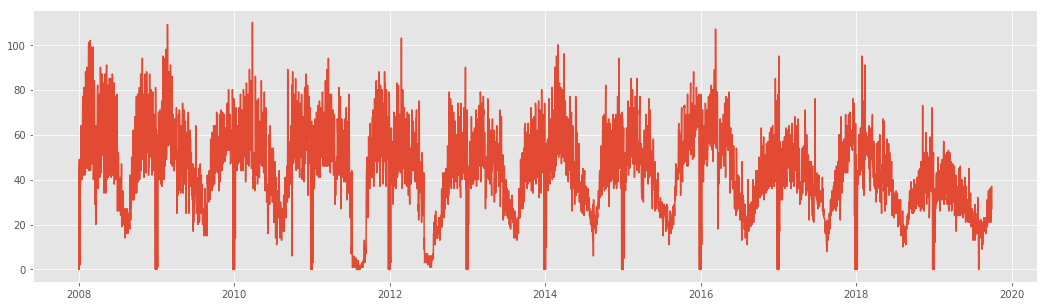

In [56]:
plt.plot(palmera_choco['units_ordered'])

#Important note: due to a bug in prophet series.plot() does not work

In [57]:
palmera_choco['units_ordered'].describe()

count    4291.000000
mean       43.670007
std        18.076184
min         0.000000
25%        32.000000
50%        43.000000
75%        55.000000
max       110.000000
Name: units_ordered, dtype: float64

As wec can see, the series is possibly stationary: it has (at first glance) no trend, and no changes in variance.

    
We can also see that its mean value is about 43, and that there is no much difference between its mean and its median value, what is a good sign for the skewness.

We can also see that the series has a great dispersion in its daily values.

In order to smooth it and get some other insights, let's get and plot the series for the monthly average data.

### 1.2) Monthly averages and monthly seasonality

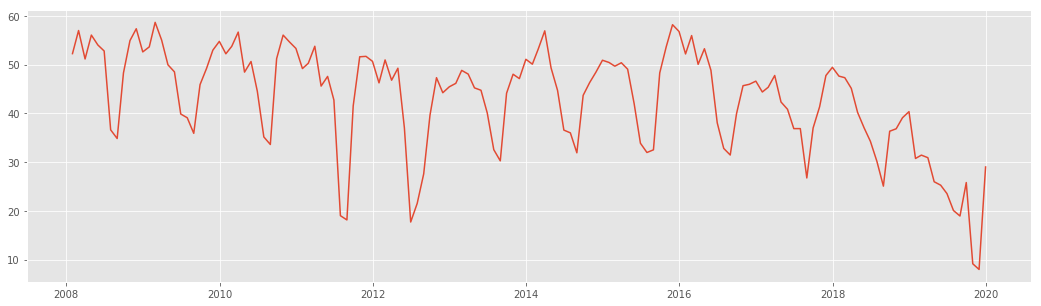

In [33]:
monthly  = palmera_choco.reset_index().groupby(pd.Grouper(key='order_date', freq='M'))['units_ordered'].mean()
plt.plot(monthly)
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as orders are always high at the beginning and end of the year.

We can see also that the series lacks a clear trend.

We also can see that the series presents minimums once a year, being more pronounced at 2011 and 2012.

We aree going to plot a couple of years to check where these minimums occur.

In [34]:
monthly.reset_index()

,order_date,units_ordered
0,2008-01-31,52.258065
1,2008-02-29,57.000000
2,2008-03-31,51.161290
3,2008-04-30,56.066667
4,2008-05-31,54.032258
5,2008-06-30,52.800000
6,2008-07-31,36.612903
7,2008-08-31,34.838710
8,2008-09-30,48.300000
9,2008-10-31,54.935484


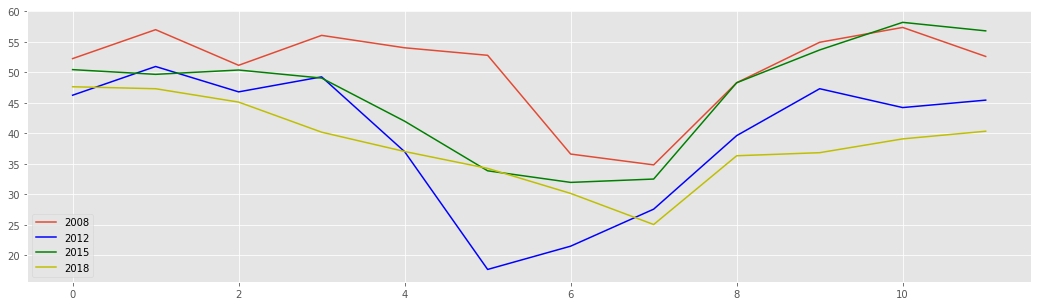

In [35]:
plt.plot(monthly['2008'].reset_index()['units_ordered'])
plt.plot(monthly['2012'].reset_index()['units_ordered'], color='b')
plt.plot(monthly['2015'].reset_index()['units_ordered'], color='g')
plt.plot(monthly['2018'].reset_index()['units_ordered'], color='y')
plt.legend(['2008','2012','2015','2018'])
plt.show()

As we can see, for 3 out of the 4 values plotted, the mininum value is found in the month of September.

For the fourth series, the minimum appears at June.

We have found that there is a clear yearly seasonality in our series.

Talking about seasonality, we are going to check now for autocorrelations, and we will use the information that we have extracted for our graphs above to use it in our favor when looking for such autocorrelations.

### 1.3) Autocorrelation, ACF and PACF

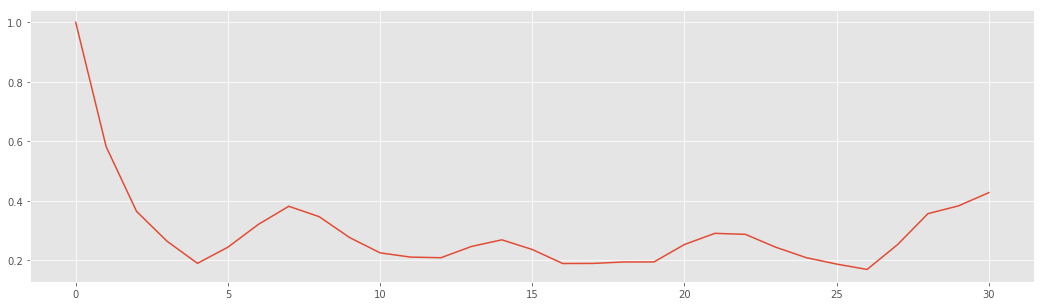

In [36]:
p_choc_acf=stto.acf(palmera_choco['units_ordered'], nlags=30)

plt.plot(p_choc_acf)

As we can see, our series presents a clear weekly autocorrelation (of about 0.8).

As we know, if the value n has an relation to value n-7 of value 0.8, then will present a correlation with the value n-14 of 0.64, and a correlation of 0.512 with the value n-21 and so on.

This is why the acf returns us all these peaks.

We are going now to check for autocorrelations in a more ample spectrum:

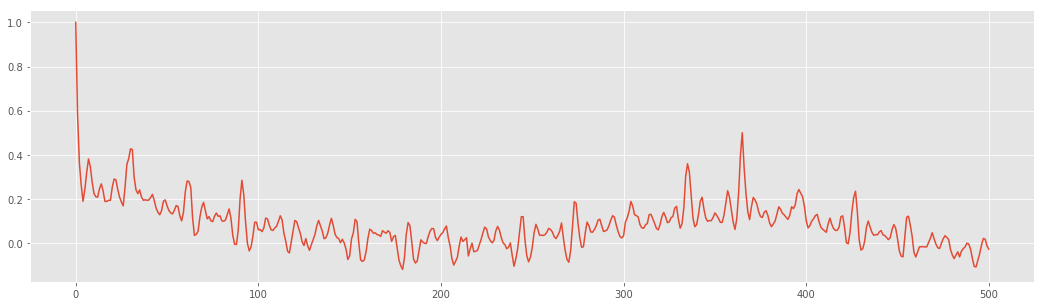

In [37]:
p_choc_acf=stto.acf(palmera_choco['units_ordered'], nlags=500)

plt.plot(p_choc_acf)

As we can see, there is a sinusoidal behaviour, and that the series presents a peak at around lag 365.

We are checking that using our average monthly data, so we can get rid off the strong autocorrelations found in our daily series.

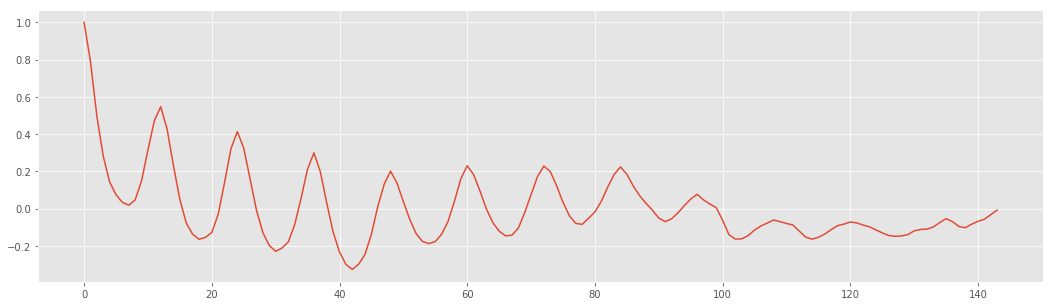

In [38]:
p_choc_acf=stto.acf(monthly, nlags=500)

plt.plot(p_choc_acf)

We find a strong relationship involving each month with the previous, of about 0.8 again.

Finally, we are checking the partial autocorrelation function, that, instead of finding correlations of present with lags like ACF, it finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation. 

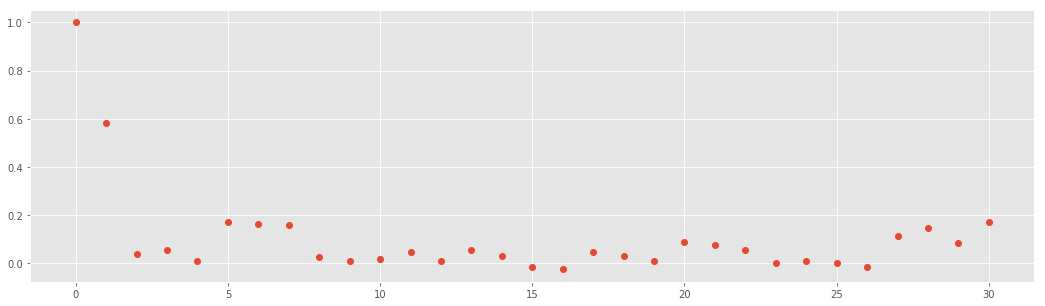

In [39]:
p_choc_acf=stto.pacf(palmera_choco['units_ordered'], nlags=30)

plt.plot(p_choc_acf, 'o')

As we can see, there is still a strong relationship with values of orders -1 and -7.

We are going now to decompose the series using the seasonal_decompose tool provided in the statsmodel package.

This method uses moving averages to detrend the series and extract the seasonality.

It will give us another first impression on what we can expect about its behaviour, and also what methods should be in order for its analysis and forescasting.

### 1.4) Series decomposition

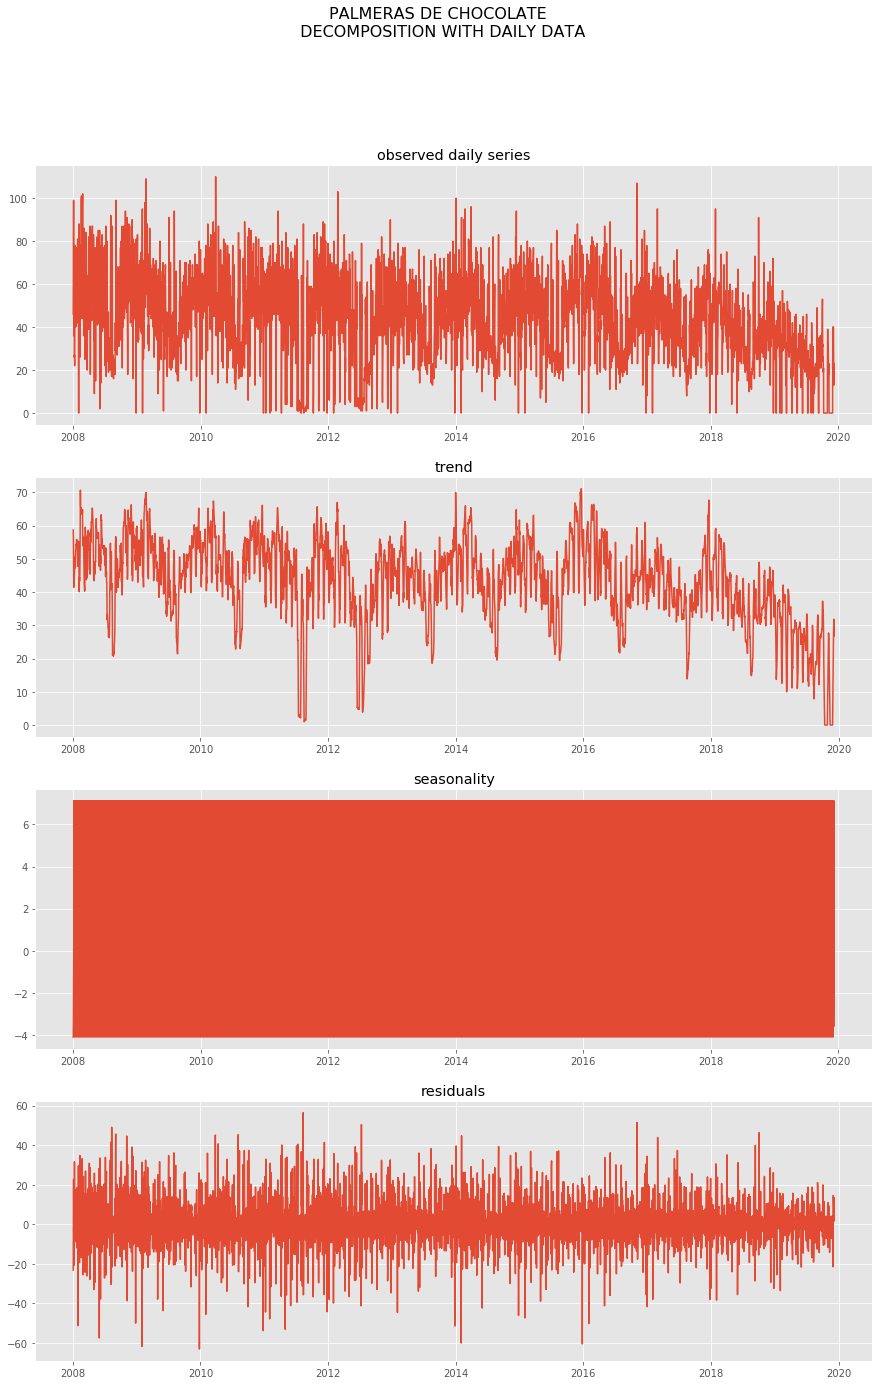

In [40]:
decomposition = seasonal.seasonal_decompose(palmera_choco['units_ordered'], model='additive')

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,22))

fig.suptitle('PALMERAS DE CHOCOLATE \n DECOMPOSITION WITH DAILY DATA', fontsize=16)

ax1.plot(decomposition.observed)
ax1.set_title('observed daily series')

ax2.plot(decomposition.trend)
ax2.set_title('trend')

ax3.plot(decomposition.seasonal)
ax3.set_title('seasonality')

ax4.plot(decomposition.resid)
ax4.set_title('residuals');


We cannot see a thing with the whole series, due to the constraints of the image. We are going to run the same procedure with just one year of data:

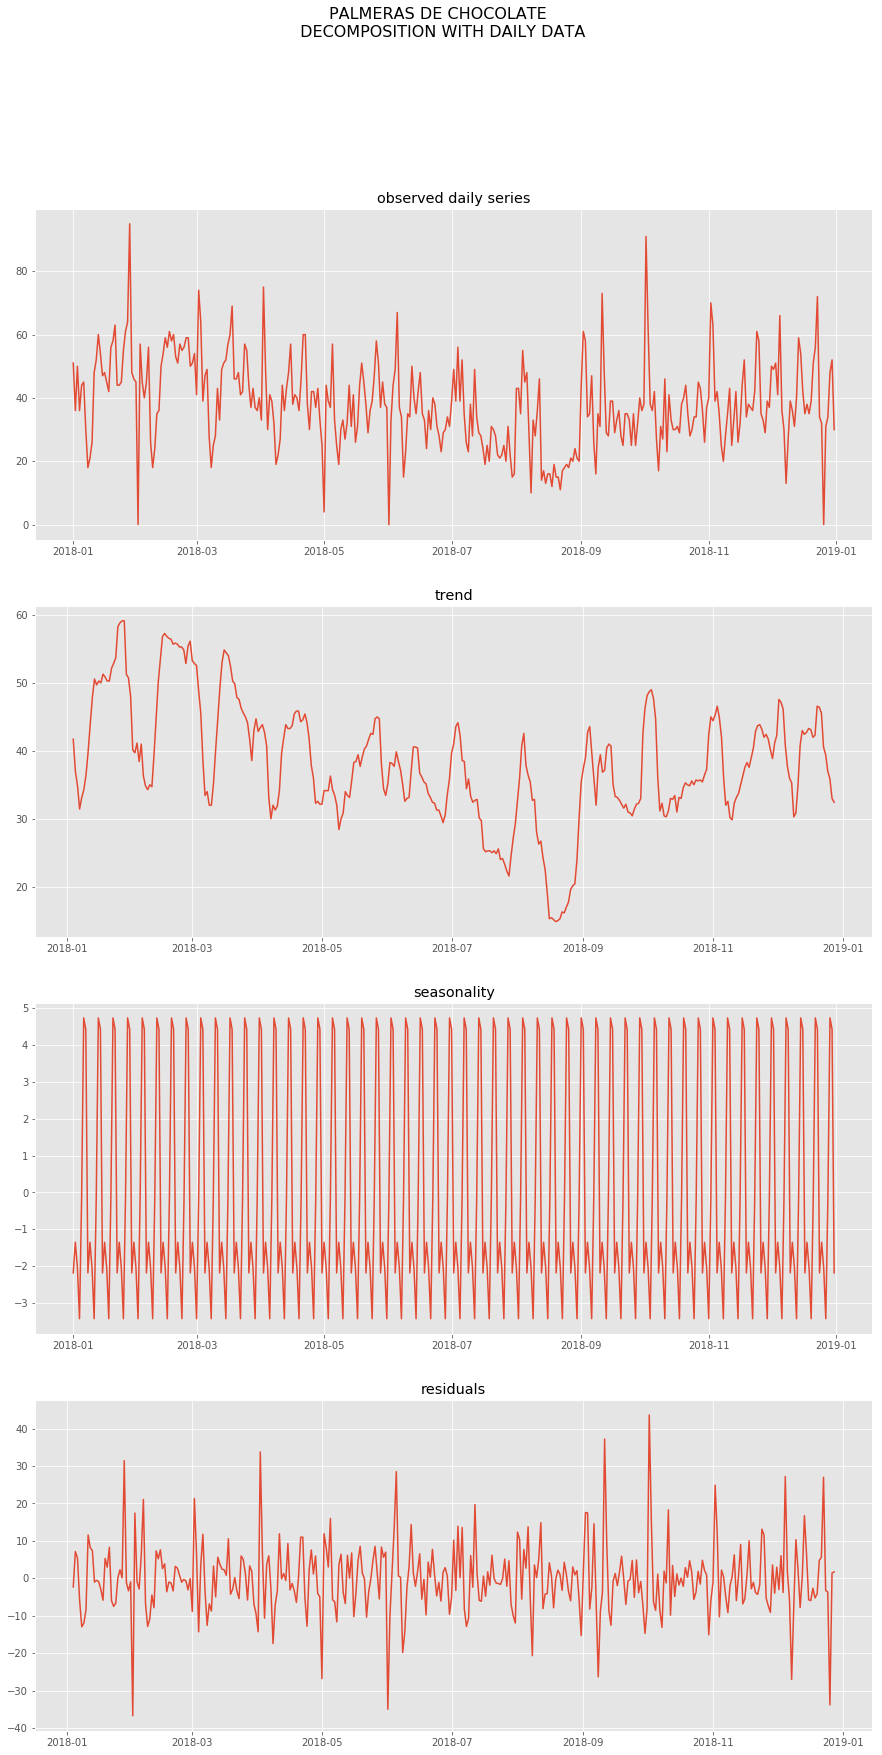

In [41]:
decomposition = seasonal.seasonal_decompose(palmera_choco.loc['2018','units_ordered'], model='additive')

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,28))

fig.suptitle('PALMERAS DE CHOCOLATE \n DECOMPOSITION WITH DAILY DATA', fontsize=16)

ax1.plot(decomposition.observed)
ax1.set_title('observed daily series')

ax2.plot(decomposition.trend)
ax2.set_title('trend')

ax3.plot(decomposition.seasonal)
ax3.set_title('seasonality')

ax4.plot(decomposition.resid)
ax4.set_title('residuals');




From this decomposition we can extract two main conclusions:

* There is a strong seasonality week component.

* As we can see, the dcomposition is not working well for the series of the daily data. Let's see what it can do with the series of monthly averages:

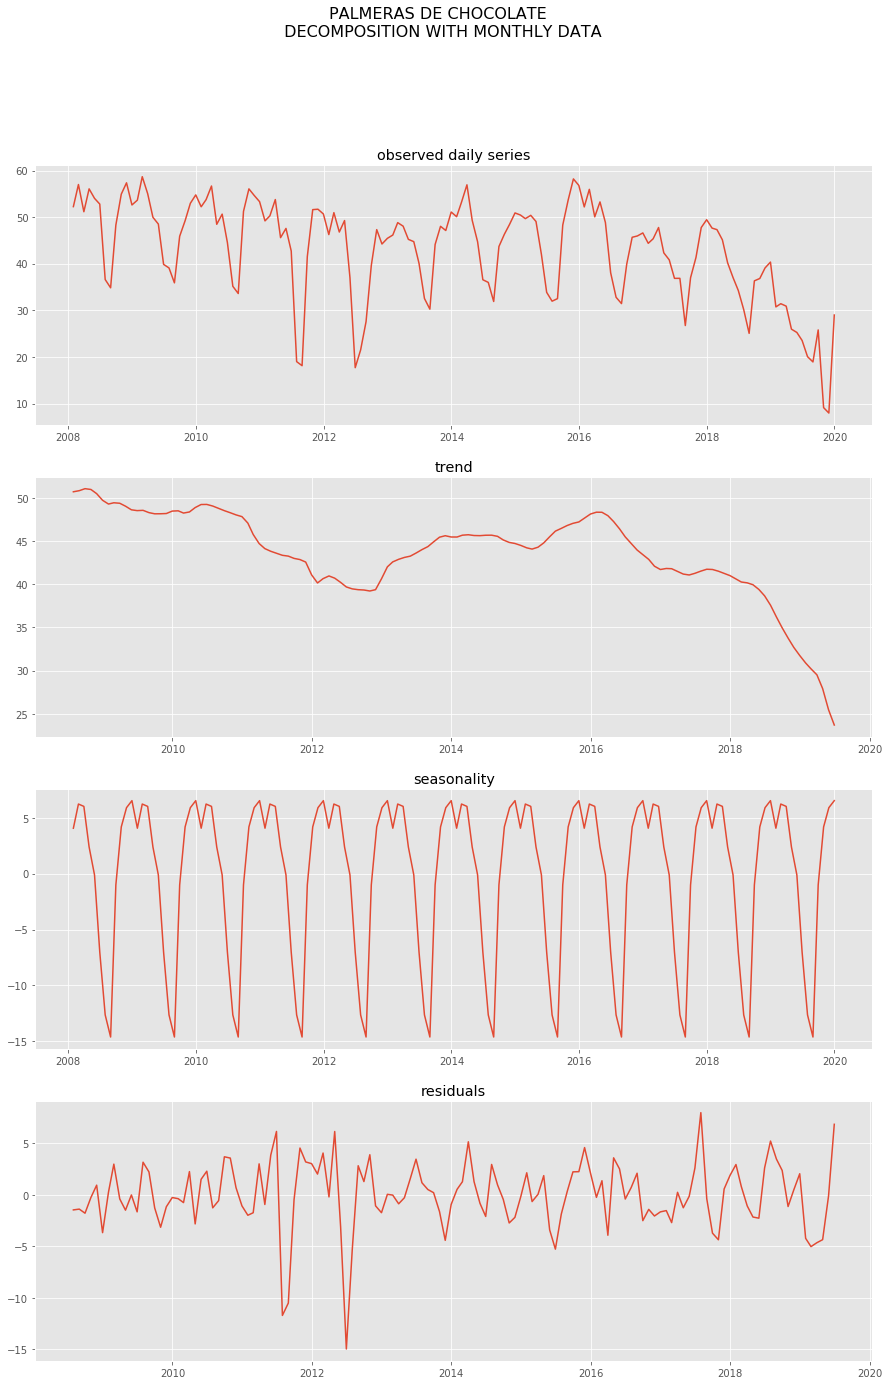

In [42]:
decomposition = seasonal.seasonal_decompose(monthly, model='additive')

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,22))

fig.suptitle('PALMERAS DE CHOCOLATE \n DECOMPOSITION WITH MONTHLY DATA', fontsize=16)

ax1.plot(decomposition.observed)
ax1.set_title('observed daily series')

ax2.plot(decomposition.trend)
ax2.set_title('trend')

ax3.plot(decomposition.seasonal)
ax3.set_title('seasonality')

ax4.plot(decomposition.resid)
ax4.set_title('residuals');


# 2) Models application

### 2.0) Split Train-Test & Initialize Results Dictionary

In [43]:
# With Feature
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

In [44]:
# Without Features
train_size = int(len(palmera_choco["units_ordered"]) * 0.70)
train, test = palmera_choco.iloc[0:train_size,0], palmera_choco.iloc[train_size:,0]

In [45]:
# Error per model Dictionary

mse_all_models = {} 

### 2.1) ARIMA

The ARIMA model for time series analysis and forecasting can be tricky to configure, for this reason we will use Grid Search to automate the process of training and evaluating ARIMA models on different combinations of model hyperparameters.
We will be following for the following notebook as a base line: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
    

The steps that suggested to follow are:

1. Split the dataset into training and test sets.
2. Walk the time steps in the test dataset.
3. Train an ARIMA model.
4. Make a one-step prediction.
5. Store prediction; get and store actual observation.
6. Calculate error score for predictions compared to expected values.

The dataset is split in two: 66% for the initial training dataset and the remaining 34% for the test dataset.
Each time step of the test set is iterated. Just one iteration provides a model that you could use to make predictions on new data. The iterative approach allows a new ARIMA model to be trained each time step.
A prediction is made each iteration and stored in a list. This is so that at the end of the test set, all predictions can be compared to the list of expected values and an error score calculated. In this case, a mean squared error score is calculated and returned.

In [46]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(arima_order, train , test):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

Now, we need to figure out what grid of parameters should we provide to the ARIMA model:

In [47]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values, train , test):
    print("starting...") 
    train = train.astype('float32')
    test = test.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(order, train, test)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA %s MSE=%.3f' % (best_cfg, best_score))
    return best_score


In [48]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3) # Coefficient to remove trend. The larger the order trend, the larger the value.
q_values = range(0, 3) #
#best_score=evaluate_models(p_values, d_values, q_values, train, test)

In [49]:
#mse_all_models["Arima"] = best_score

### 2.2) PROPHET

In [50]:
train_for_prophet = train.reset_index()
train_for_prophet = train_for_prophet.rename(columns={'order_date': 'ds', 'units_ordered': 'y'})
palmera_choco_prophet_model = Prophet(interval_width=0.95)
palmera_choco_prophet_model.fit(train_for_prophet)


palmera_choco_forecast = palmera_choco_prophet_model.make_future_dataframe(periods=36, freq='MS')
palmera_choco_forecast = palmera_choco_prophet_model.predict(palmera_choco_forecast)

plt.figure(figsize=(18, 6))
palmera_choco_prophet_model.plot(palmera_choco_forecast, xlabel = 'Date', ylabel = 'Orders')
plt.title('Palmera Chocolate- Oreders Forecast')

NameError: name 'Prophet' is not defined

In [ ]:
test_for_prophet = test.reset_index()
test_for_prophet = test_for_prophet.rename(columns={'order_date': 'ds', 'units_ordered': 'y'})
predictions = palmera_choco_prophet_model.predict(test_for_prophet)

In [ ]:
mse_prophet = mean_squared_error(test_for_prophet["y"], predictions["yhat"])
mse_prophet

In [ ]:
df_cv = cross_validation(palmera_choco_prophet_model, initial='366 days', period='365 days', horizon = '20 days')
df_cv.head()

In [ ]:
df_p = performance_metrics(df_cv)
df_p.head(5)

In [ ]:
df_p['mse'].plot()

In [ ]:
mse_all_models["Prophet"] = mse_prophet

### 2.2) RANDOM FOREST

Lets now try rarandom forest with only the time series as input. The steps we will need to follow are:

1. Transform the data: each row should contain the features (previous days, matches, etc)
2. Fit the model with train
3. Predict with test
4. Evaluate the error.

Lets start creating the function that will transform the data, which was adapted from the following site: https://machinelearningmastery.com/how-to-develop-machine-learning-models-for-multivariate-multi-step-air-pollution-time-series-forecasting/

In [ ]:
def data_transformation(series, n_lag, lead_time):
    """ Takes a series, a number of lag observations to use as input, 
    and a forecast lead time to predict, then will return a list of input/out 
    rows drawn from the series """

    data = list()
    # enumerate observations and create input/output patterns
    for i in range(n_lag, len(series)):
        end_ix = i + (lead_time - 1)
        # check if can create a pattern
        if end_ix >= len(series):
            break
        # retrieve input and output
        start_ix = i - n_lag
        row = series[start_ix:i] + [series[end_ix]]
        data.append(row)
    return list(data)

It is important to note that in order to transform the data we need to provide the function with the previous number of days that we want to consider for the prediction, as well as the gap between the prediction and the data:

In [ ]:
# Take into account the las 365 days
previous_days = 365

#Predict the next day
predict_n_plus = 1

In [ ]:
#Required by data_transformation
train_list = list(train)
test_list = list(test)

#Lets keep the index
index_train = train[(previous_days+predict_n_plus-1):].index
index_test = test[(previous_days+predict_n_plus-1):].index

#Transform test and train and keeps the 
train_rf = pd.DataFrame(data_transformation(train_list, previous_days, predict_n_plus), index = index_train)
test_rf = pd.DataFrame(data_transformation(test_list, previous_days, predict_n_plus), index = index_test)

# Create random forest object
clf = RandomForestRegressor(max_depth=4)

# Split the features form the target variable
X_train = train_rf[train_rf.columns[:-1]]
y_train = train_rf[train_rf.columns[-1]]

X_test = test_rf[test_rf.columns[:-1]]
y_test = test_rf[test_rf.columns[-1]]

# Train the model
clf.fit(X_train,y_train)

# Calculate the error
mse = mean_squared_error(clf.predict(X_test),y_test)
mse

Oh lah lah, fantastic mse! 

Lets have a look both the predicted series agains the observed:

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(16,6))
ax1.plot(clf.predict(X_test))
ax1.plot(list(y_test))
ax1.legend(['Prediction',"Observed"])

Its a bit complicated to see anything, lets zoom at both the start and end:

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(16,6))
ax1.plot(clf.predict(X_test)[:100])
ax1.plot(list(y_test)[:100])
ax1.legend(['Prediction',"Observed"])

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(16,6))
ax1.plot(clf.predict(X_test)[-100:])
ax1.plot(list(y_test)[-100:])
ax1.legend(['Prediction',"Observed"])

As expected the closer the observations are to the trained data, the better it looks.

Lets now have a look at what is the model doing with the input variables:

In [ ]:
clf.feature_importances_

In [ ]:
max_val = clf.feature_importances_.max()
max_val_day = list(clf.feature_importances_).index(max_val)

print(f"Most important feature is day {max_val_day}, with a total weight of {max_val}")

This is both expected and unexpected. What we expected is to see the previous value as the most relevant one for the model, however, what we didn't expect is so many features adding 0 value.

Nonetheless this basic Random Forest is just the beginning, lets now play with hyperparameters input data etc...

It is important to note that in order to transform the data we need to provide the function with the previous number of days that we want to consider for the prediction. From the time series analysis that we did before, we have some insight that -7 days, and -365 days may be very important, however we don't know which model will perform best, hence we will train with different timeframes. 

In [ ]:
previous_days = [1,7,30,365]
predict_n_plus = [1,2,3,4,5,6,7]


Lets now transform now create another function that:
1. Splits train and test into the right formats required by the model.
2. Trains the model.
3. Predicts and evaluate.

And lets save the results to see which is the best performing model:


In [ ]:
def train_test_to_random_forest_shape (previous_days, train, test, predict_n_plus):
    # Conversion to list is needed for the transformation function
    train_list = list(train)
    test_list = list(test)
    
    #Lets keep the index
    index_train = train[(previous_days+predict_n_plus-1):].index
    index_test = test[(previous_days+predict_n_plus-1):].index
    
    #Transform test and train and keeps the 
    train_rf = pd.DataFrame(data_transformation(train_list, previous_days, predict_n_plus), index = index_train)
    test_rf = pd.DataFrame(data_transformation(test_list, previous_days, predict_n_plus), index = index_test)
    
    return(train_rf,test_rf)


No it is time to iterate over the number of previous days, and evaluate the different models:

In [ ]:
random_forst_errors = {}
for d in previous_days:
    for p in predict_n_plus:
        # Transform the data
        (train_rf,test_rf) = train_test_to_random_forest_shape(d,train,test, p)
        # Create random forest object
        clf = RandomForestRegressor(max_depth=4)

        # Split the features form the target variable
        X_train = train_rf[train_rf.columns[:-1]]
        y_train = train_rf[train_rf.columns[-1]]

        X_test = test_rf[test_rf.columns[:-1]]
        y_test = test_rf[test_rf.columns[-1]]

        # Train the model
        clf.fit(X_train,y_train)

        # Calculate the error
        mse = mean_squared_error(clf.predict(X_test),y_test)

        random_forst_errors[str(d) + " : " + str(p)] = mse

random_forst_errors

Improvements:
- One model per day of future prediction (so.. one model for n+1, one model for n+2, etc)
- Aggregate by week all data.
- Multivarient Random Forest
- https://www.r-bloggers.com/time-series-forecasting-with-random-forest/
- Retraining removing columns with 0

Transfer learning to other 